In [1]:
# 从shiningspectrum中导入pretreatment
from shiningspectrum import pretreatment
#从shiningspectrum中导入database
from shiningspectrum import database
#导入peak_processing
from shiningspectrum import peak_processing
import os
import matplotlib.pyplot as plt
import numpy as np

import math
import pickle
#import matplotlib.pyplot as plt
#import numpy as np
#from ramannoodles import spectrafit
from ramannoodles import shoyu
from ramannoodles import peakidentify

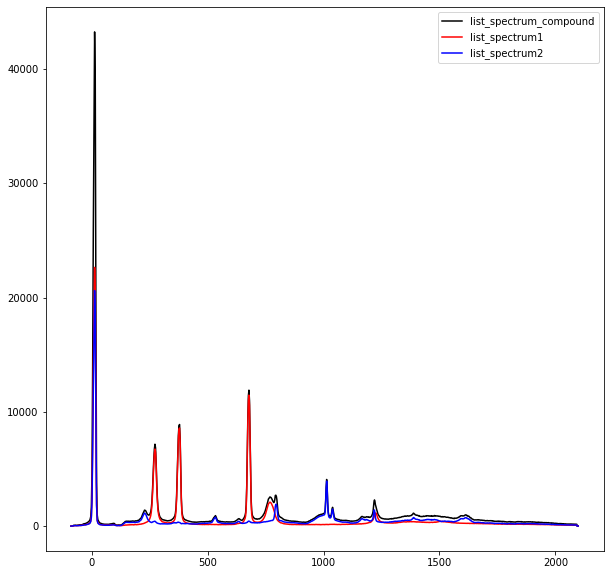

In [2]:
data_path=os.getcwd()+"\\Prepare incoming data"

file_data1 = database.read_file(data_path, "氯仿.txt")#67-66-3
file_data2 = database.read_file(data_path, "甲苯.txt")#108-88-3

list_spectrum1 = database.data_extraction(file_data1)
list_spectrum2 = database.data_extraction(file_data2)

list_spectrum_compound = [list_spectrum1[0],list(np.array(list_spectrum1[1])+np.array(list_spectrum2[1]))]

plt.figure(figsize=(10,10))
plt.plot(list_spectrum_compound[0],list_spectrum_compound[1],"k-",label="list_spectrum_compound")
plt.plot(list_spectrum1[0],list_spectrum1[1],"r-",label="list_spectrum1")

plt.plot(list_spectrum2[0],list_spectrum2[1],"b-",label="list_spectrum2")
plt.legend()

In [3]:
all_spectrum = database.read_all("raman_database")

In [4]:
all_spectrum.keys()

dict_keys(['64-17-5', '67-66-3', '108-90-7', '108-88-3', '108-95-2'])

In [5]:
def shining2noodles(all_spectrum):
    list_of_compounds = []
    for key in list(all_spectrum.keys()):
        x = np.array(all_spectrum[key][0])
        y = np.array(all_spectrum[key][1])
        
        list_of_compounds.append(({"title":key,"x":x,"y":y}))
        
    return list_of_compounds
    



In [6]:
list_of_compounds = shining2noodles(all_spectrum)

In [7]:
[list_of_compounds[0],list_of_compounds[3]]

[{'title': '64-17-5',
  'x': array([ -89.568,  -86.697,  -83.828, ..., 2095.591, 2097.12 , 2098.648]),
  'y': array([-1.51,  2.52,  1.51, ..., -0.5 , -0.5 , -5.54])},
 {'title': '108-88-3',
  'x': array([ -89.568,  -86.697,  -83.828, ..., 2095.591, 2097.12 , 2098.648]),
  'y': array([-3.38, -1.38, -0.38, ..., -3.38,  3.62,  1.62])}]

In [48]:
#unknown_x=np.array(list_spectrum_compound[0])
#unknown_y=np.array(list_spectrum_compound[1])

#peakidentify.peak_assignment(unknown_x, unknown_y, list_of_compounds)

In [8]:
#函数定义

def peak_assignment(unknown_x, unknown_y, known_compound_list,
                    precision=0.03, plot=True):
    """This function is a wrapper function from which all classification of peaks occurs."""

    #Handling errors in inputs.
    if not isinstance(unknown_x, np.ndarray):
        raise TypeError("Passed value of `unknown_x` is not a np.ndarray! Instead, it is: "
                        + str(type(unknown_x)))

    if not isinstance(unknown_y, np.ndarray):
        raise TypeError("Passed value of `unknown_y` is not a np.ndarray! Instead, it is: "
                        + str(type(unknown_y)))

    if not isinstance(known_compound_list, list):
        raise TypeError("Passed value of `known_compound_list` is not a list! Instead, it is: "
                        + str(type(known_compound_list)))

    #Now we need to check the elements within the known_compound_list to make sure they are correct.
    for i, _ in enumerate(known_compound_list):
        if not isinstance(known_compound_list[i], dict):
            raise TypeError("""Passed value within `known_compound_list` is not a dictionary!
            Instead, it is: """ + str(type(known_compound_list[i])))

    if not isinstance(precision, (float, int)):
        raise TypeError("""Passed value of `precision` is not a float or int!
        Instead, it is: """ + str(type(precision)))

    if not isinstance(plot, bool):
        raise TypeError("""Passed value of `plot` is not a Boolean!
        Instead, it is: """ + str(type(plot)))
    
    #Lets identify the peaks in the unknown spectrum.
    unknown_peaks = data_report(unknown_x, unknown_y)[0]
    print("data_report成功")

    #OK, next identify all of the peaks present in the known compound set.
    #For efficiency, we'll also compare them against the unknown in the same for loop.
    known_compound_peaks = []
    assignment_matrix = []

    for i, _ in enumerate(known_compound_list):
        known_compound_peaks.append(
            compound_report(known_compound_list[i])[0])
        print("The peaks that we found for "
              + str(known_compound_list[i]['title']) + " are: ")
        print(known_compound_peaks[i])
        assignment_matrix.append(compare_unknown_to_known(unknown_peaks,
                                                          known_compound_peaks[i],
                                                          precision))

    #Ok, so that generates a full association matrix that contains everything
    #we need to assign peaks.
    #Now, let's go through and actually assign text to peaks.
    #print("spectrafit.data_report成功")
    unknown_peak_assignments = peak_position_comparisons(unknown_peaks,
                                                         known_compound_peaks,
                                                         known_compound_list,
                                                         assignment_matrix)
    print(unknown_peak_assignments)
    
    percentages = percentage_of_peaks_found(known_compound_peaks,
                                            assignment_matrix,
                                            known_compound_list)

    if plot:
        plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks,
                                  unknown_peak_assignments,percentages)

    #percentages = percentage_of_peaks_found(known_compound_peaks,
    #                                        assignment_matrix,
    #                                        known_compound_list)
    print(percentages)
    
    return percentages


def compare_unknown_to_known(combined_peaks, known_peaks, precision):
    """This function takes in peak positions for the spectrum to be
    analyzed and a single known compound and determines if the peaks
    found in the known compound are present in the unknown spectrum."""

    #Handling errors in inputs.
    if not isinstance(combined_peaks, list):
        raise TypeError("""Passed value of `combined_peaks` is not a list!
        Instead, it is: """ + str(type(combined_peaks)))

    if not isinstance(known_peaks, list):
        raise TypeError("""Passed value of `known_peaks` is not a list!
        Instead, it is: """ + str(type(known_peaks)))

    if not isinstance(precision, (float, int)):
        raise TypeError("""Passed value of `precision` is not a float or int!
        Instead, it is: """ + str(type(precision)))

    assignment_matrix = np.zeros(len(combined_peaks))
    peaks_found = 0
    for i, _ in enumerate(combined_peaks):
        for j, _ in enumerate(known_peaks):
            # instead of If, call peak_1D_score
            if math.isclose(combined_peaks[i], known_peaks[j],
                            rel_tol=precision):
                # Instead of using a 1, just input the score
                # from the score calculator.
                # Bigger is better.
                # Storing only the second component in the list.
                assignment_matrix[i] = 1
                peaks_found += 1
                continue
            else:
                pass
        if peaks_found == len(known_peaks):
            continue
        else:
            pass
    return assignment_matrix


def peak_position_comparisons(unknown_peaks, known_compound_peaks,
                              known_compound_list,
                              association_matrix):
    """This function takes in an association matrix and turns the numbers
    given by said matrix into a text label."""

    #Handling errors in inputs.
    if not isinstance(unknown_peaks, list):
        raise TypeError("""Passed value of `unknown_peaks` is not a list!
        Instead, it is: """ + str(type(unknown_peaks)))

    if not isinstance(known_compound_peaks, list):
        raise TypeError("""Passed value of `known_compound_peaks` is not a list!
        Instead, it is: """ + str(type(known_compound_peaks)))

    if not isinstance(known_compound_list, list):
        raise TypeError("""Passed value of `known_compound_list` is not a list!
        Instead, it is: """ + str(type(known_compound_list)))

    #Now we need to check the elements within the known_compound_list to make sure they are correct.
    for i, _ in enumerate(known_compound_list):
        if not isinstance(known_compound_list[i], dict):
            raise TypeError("""Passed value within `known_compound_list` is not a dictionary!
            Instead, it is: """ + str(type(known_compound_list[i])))

    if not isinstance(association_matrix, list):
        raise TypeError("""Passed value of `association_matrix` is not a float or int!
        Instead, it is: """ + str(type(association_matrix)))

    unknown_peak_assignment = []
    #Step through the unknown peaks to make an assignment for each unknown peak.

    for i, _ in enumerate(unknown_peaks):
        #We might be able to make a small performance improvement if we were to somehow
        #not search the peaks we already had searched, but that seems to not be trivial.
        position_assignment = []
        #We'll need an outer loop that walks through all the different compound positions
        for j, _ in enumerate(known_compound_peaks):
            if association_matrix[j][i] == 1:
                position_assignment.append(known_compound_list[j]['title'])
            else:
                pass
        if position_assignment == []:
            position_assignment.append("Unassigned")
        unknown_peak_assignment.append(position_assignment)

    return unknown_peak_assignment


def percentage_of_peaks_found(known_peaks, association_matrix, list_of_known_compounds):
    """This function takes in a list of classified peaks, and returns a percentage of
    how many of the material's peaks are found in the unknown spectrum.
    This can be used as a metric of confidence."""

    #Handle bad inputs
    if not isinstance(known_peaks, list):
        raise TypeError("""Passed value of `known_peaks` is not a list!
        Instead, it is: """ + str(type(known_peaks)))

    if not isinstance(list_of_known_compounds, list):
        raise TypeError("""Passed value of `list_of_known_compounds` is not a list!
        Instead, it is: """ + str(type(list_of_known_compounds)))

    # Now we need to check the elements within the
    # list_of_known_compounds to make sure they are correct.
    for i, _ in enumerate(list_of_known_compounds):
        if not isinstance(list_of_known_compounds[i], dict):
            raise TypeError("""Passed value within `list_of_known_compounds` is not a dictionary!
            Instead, it is: """ + str(type(list_of_known_compounds[i])))

    if not isinstance(association_matrix, list):
        raise TypeError("""Passed value of `association_matrix` is not a float or int!
        Instead, it is: """ + str(type(association_matrix)))

    percentage_dict = {}
    for i, _ in enumerate(list_of_known_compounds):
        count_number = sum(association_matrix[i])
        percentage_dict[list_of_known_compounds[i]
                        ['title']] = (count_number / len(known_peaks[i])) * 100

    return percentage_dict


def plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks, unknown_peak_assignments,percentages):
    """This function plots a set of unknown peaks, and plots the assigned classification given by
    the functions within peakassignment"""

    #Handling errors in inputs.
    if not isinstance(unknown_peaks, list):
        raise TypeError("""Passed value of `unknown_peaks` is not a list!
        Instead, it is: """ + str(type(unknown_peaks)))

    if not isinstance(unknown_x, (list, np.ndarray)):
        raise TypeError("""Passed value of `unknown_x` is not a list or ndarray!
        Instead, it is: """ + str(type(unknown_x)))

    if not isinstance(unknown_y, (list, np.ndarray)):
        raise TypeError(""" Passed value of `unknown_y` is not a list or ndarray!
        Instead, it is: """ + str(type(unknown_y)))

    #Now we need to check the elements within the unknown_peak_assignment
    #to make sure they are correct.
    #这里可能有问题，注释掉
    print('unknown_peak_assignments is {}'.format(unknown_peak_assignments))
#    for i, _ in enumerate(unknown_peak_assignments):
#        if not isinstance(unknown_peak_assignments[i], str):
#            raise TypeError("""Passed value within `unknown_peak_assignment` is not a string!
#            Instead, it is: """ + str(type(unknown_peak_assignments[i])))

    # 不含   'black':                '#000000','antiquewhite':         '#FAEBD7',    'beige':                '#F5F5DC',
    #'bisque':               '#FFE4C4',
    #'blanchedalmond':       '#FFEBCD',    'aliceblue':            '#F0F8FF',
    cnames = {
    'aqua':                 '#00FFFF',
    'aquamarine':           '#7FFFD4',
    'azure':                '#F0FFFF',
    'blue':                 '#0000FF',
    'blueviolet':           '#8A2BE2',
    'brown':                '#A52A2A',
    'burlywood':            '#DEB887',
    'cadetblue':            '#5F9EA0',
    'chartreuse':           '#7FFF00',
    'chocolate':            '#D2691E',
    'coral':                '#FF7F50',
    'cornflowerblue':       '#6495ED',
    'cornsilk':             '#FFF8DC',
    'crimson':              '#DC143C',
    'cyan':                 '#00FFFF',
    'darkblue':             '#00008B',
    'darkcyan':             '#008B8B',
    'darkgoldenrod':        '#B8860B',
    'darkgray':             '#A9A9A9',
    'darkgreen':            '#006400',
    'darkkhaki':            '#BDB76B',
    'darkmagenta':          '#8B008B',
    'darkolivegreen':       '#556B2F',
    'darkorange':           '#FF8C00',
    'darkorchid':           '#9932CC',
    'darkred':              '#8B0000',
    'darksalmon':           '#E9967A',
    'darkseagreen':         '#8FBC8F',
    'darkslateblue':        '#483D8B',
    'darkslategray':        '#2F4F4F',
    'darkturquoise':        '#00CED1',
    'darkviolet':           '#9400D3',
    'deeppink':             '#FF1493',
    'deepskyblue':          '#00BFFF',
    'dimgray':              '#696969',
    'dodgerblue':           '#1E90FF',
    'firebrick':            '#B22222',
    'floralwhite':          '#FFFAF0',
    'forestgreen':          '#228B22',
    'fuchsia':              '#FF00FF',
    'gainsboro':            '#DCDCDC',
    'ghostwhite':           '#F8F8FF',
    'gold':                 '#FFD700',
    'goldenrod':            '#DAA520',
    'gray':                 '#808080',
    'green':                '#008000',
    'greenyellow':          '#ADFF2F',
    'honeydew':             '#F0FFF0',
    'hotpink':              '#FF69B4',
    'indianred':            '#CD5C5C',
    'indigo':               '#4B0082',
    'ivory':                '#FFFFF0',
    'khaki':                '#F0E68C',
    'lavender':             '#E6E6FA',
    'lavenderblush':        '#FFF0F5',
    'lawngreen':            '#7CFC00',
    'lemonchiffon':         '#FFFACD',
    'lightblue':            '#ADD8E6',
    'lightcoral':           '#F08080',
    'lightcyan':            '#E0FFFF',
    'lightgoldenrodyellow': '#FAFAD2',
    'lightgreen':           '#90EE90',
    'lightgray':            '#D3D3D3',
    'lightpink':            '#FFB6C1',
    'lightsalmon':          '#FFA07A',
    'lightseagreen':        '#20B2AA',
    'lightskyblue':         '#87CEFA',
    'lightslategray':       '#778899',
    'lightsteelblue':       '#B0C4DE',
    'lightyellow':          '#FFFFE0',
    'lime':                 '#00FF00',
    'limegreen':            '#32CD32',
    'linen':                '#FAF0E6',
    'magenta':              '#FF00FF',
    'maroon':               '#800000',
    'mediumaquamarine':     '#66CDAA',
    'mediumblue':           '#0000CD',
    'mediumorchid':         '#BA55D3',
    'mediumpurple':         '#9370DB',
    'mediumseagreen':       '#3CB371',
    'mediumslateblue':      '#7B68EE',
    'mediumspringgreen':    '#00FA9A',
    'mediumturquoise':      '#48D1CC',
    'mediumvioletred':      '#C71585',
    'midnightblue':         '#191970',
    'mintcream':            '#F5FFFA',
    'mistyrose':            '#FFE4E1',
    'moccasin':             '#FFE4B5',
    'navajowhite':          '#FFDEAD',
    'navy':                 '#000080',
    'oldlace':              '#FDF5E6',
    'olive':                '#808000',
    'olivedrab':            '#6B8E23',
    'orange':               '#FFA500',
    'orangered':            '#FF4500',
    'orchid':               '#DA70D6',
    'palegoldenrod':        '#EEE8AA',
    'palegreen':            '#98FB98',
    'paleturquoise':        '#AFEEEE',
    'palevioletred':        '#DB7093',
    'papayawhip':           '#FFEFD5',
    'peachpuff':            '#FFDAB9',
    'peru':                 '#CD853F',
    'pink':                 '#FFC0CB',
    'plum':                 '#DDA0DD',
    'powderblue':           '#B0E0E6',
    'purple':               '#800080',
    'red':                  '#FF0000',
    'rosybrown':            '#BC8F8F',
    'royalblue':            '#4169E1',
    'saddlebrown':          '#8B4513',
    'salmon':               '#FA8072',
    'sandybrown':           '#FAA460',
    'seagreen':             '#2E8B57',
    'seashell':             '#FFF5EE',
    'sienna':               '#A0522D',
    'silver':               '#C0C0C0',
    'skyblue':              '#87CEEB',
    'slateblue':            '#6A5ACD',
    'slategray':            '#708090',
    'snow':                 '#FFFAFA',
    'springgreen':          '#00FF7F',
    'steelblue':            '#4682B4',
    'tan':                  '#D2B48C',
    'teal':                 '#008080',
    'thistle':              '#D8BFD8',
    'tomato':               '#FF6347',
    'turquoise':            '#40E0D0',
    'violet':               '#EE82EE',
    'wheat':                '#F5DEB3',
    'white':                '#FFFFFF',
    'whitesmoke':           '#F5F5F5',
    'yellow':               '#FFFF00',
    'yellowgreen':          '#9ACD32'}
    #colors = ['b', 'r', 'g', 'c', 'm', 'y', 'b']
    colors = list(cnames.keys())
    #fig = plt.figure(figsize=(10, 4), dpi=300)
    title_s='The sample to be tested contains :'
    for key in percentages:
        if percentages[key]==100:
            title_s=title_s+key+';'
    plt.figure(figsize=(10,10))
    plt.plot(unknown_x, unknown_y, color='black', label='Unknown Spectrum')
    
    for i, _ in enumerate(unknown_peaks):
        plt.axvline(x=unknown_peaks[i], color=colors[i],
                    label=unknown_peak_assignments[i],
                    linestyle='--')

    plt.legend(loc=0, framealpha=1)
    
    plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.ylim(unknown_y.min(), unknown_y.max())
    plt.xlim(unknown_x.min(), unknown_x.max())
    plt.title(title_s)
    plt.show()


def peak_1d_score(row_i, row_j, scoremax):
    """
    Returns scores with respect to the repricoal of the
    calculated Euclidean distance between peaks
    #√((x1-x2)^2) in 1D
    #√((x1-x2)^2 + (y1-y2)^2) in 2D

    Parameters:
        row_i (list like):  input list
        row_j (list like): input list
        scoremax (float): Euclidean reciprocal score divided by max score; default is 1

    Returns:
        scores (list): Euclidean reciprocal scores
        peaks (tuple): peaks associated with scores
    """
    # Handling errors at the input
    if not isinstance(row_i, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_i` is not a list or ndarray!
        Instead, it is: """ + str(type(row_i)))
    if not isinstance(row_j, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_j` is not a list or ndarray!
        Instead, it is: """ + str(type(row_j)))
    if not isinstance(scoremax, (float, int)):
        raise TypeError("""Passed value of `scoremax` is not a float or int!
        Instead, it is: """ + str(type(scoremax)))
    if scoremax < 0:
        raise ValueError("""Passed value of `scoremax` is not within bounds!""")

    # Initializing the variables
    scores = []
    peaks = []

    for i, _ in enumerate(row_i):
        for j, _ in enumerate(row_j):
            # Calculating distances between peaks
            distance = np.where((row_i[i] - row_j[j] > 50), np.nan,
                                math.sqrt(sum([math.pow(row_i[i] - row_j[j], 2)])))
            # Score for peaks less than 50 units apart
            if 1 / (distance + 1) > .02:
                # Dividing over the given max score
                scores.append(((1 / (distance + 1)) / scoremax))
                # Appends a tuple of the compared peaks
                peaks.append((row_i[i], row_j[j]))
            else:
                pass
    return scores, peaks


def score_max(row_i, row_j, k):
    """
    Returns list of scores sorted with respect to the peaks
    related to its output max score

    Parameters:
        row_i (list like):  input list
        row_j (list like): input list
        k (int): input integer used to sort the scores / kth highest score

    Returns:
        maxscores (list): Euclidean reciprocal score divided by max score
        maxpeaks (tuple): peaks associated with max scores
    """

    # Handling errors at the input
    if not isinstance(row_i, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_i` is not a list or ndarray!
        Instead, it is: """ + str(type(row_i)))
    if not isinstance(row_j, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_j` is not a list or ndarray!
        Instead, it is: """ + str(type(row_j)))
    if not isinstance(k, int):
        raise TypeError("""Passed value of `k` is not an int!
        Instead, it is: """ + str(type(k)))
    if k < 0:
        raise ValueError("""Passed value of `k` is not within bounds!""")
    try:
        scoremax = sorted(set(peak_1d_score(row_i, row_j, 1)[0][:]))[-k]
        maxscores, maxpeaks = peak_1d_score(row_i, row_j, scoremax)

    except Exception as e:
        print("""Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1.""")

        maxscores, maxpeaks = peak_1d_score(row_i, row_j, scoremax=1)

    return maxscores, maxpeaks


def score_sort(row_i, row_j, k):
    """
    Returns list of scores sorted

    Parameters:
        list_input (list like):  input list
        row (list like): input list
        k (int): input integer used to sort the scores / kth highest score

    Returns:
        sortedscores (list): sorted Euclidean distances
    """
    # Handling errors at the input
    if not isinstance(row_i, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_i` is not a list or ndarray!
        Instead, it is: """ + str(type(row_i)))
    if not isinstance(row_j, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_j` is not a list or ndarray!
        Instead, it is: """ + str(type(row_j)))
    if not isinstance(k, int):
        raise TypeError("""Passed value of `k` is not an int!
        Instead, it is: """ + str(type(k)))
    if k < 0:
        raise ValueError("""Passed value of `k` is not within bounds!""")

    sortedscores = []
    sortedscores.append(score_max(row_i, row_j, k))
    sortedscores.sort()

    return sortedscores


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import lmfit
from lmfit.models import PseudoVoigtModel
from peakutils.baseline import baseline
from scipy.signal import find_peaks


def subtract_baseline(y_data, deg=3, plot=False, x_data=None):
    """
    Function that fits an n-degree polynomial (default: n = 3) baseline
    to the spectral data, and subtracts it from the input data.

    Args:
        y_data (list like): The intensity data of the spectra to be baselined.
        deg (integer): (Optional) Integer value for the degree of the polynomial
                       to be used to baseline data. The value defaults to 3 if
                       no value is specified.
        plot (boolean): (Optional) Boolean value that indicates whether or not to
                        plot the baselined and original data. If true, it plots
                        both spectra on the same plot. Note that if the user wants
                        plotting functionality, x_data must be provided.
        x_data (list like): (Optional) The x-values associated with the y_data that
                            is being baselined. These values are only needed for
                            the function if the user desires plotting.

    Returns:
        y_out (list like): The baselined values of the y-axis.
    """
    # handling errors in inputs
    if not isinstance(y_data, (list, np.ndarray)):
        raise TypeError('Passed value of `y_data` is not a list or numpy.ndarray! Instead, it is: '
                        + str(type(y_data)))
    y_base = baseline(y_data, deg=deg, max_it=200)
    # to avoid strange results,
    # change all negative values to zero
    yb_plus = [0 if i < 0 else i for i in y_base]
    y_out = y_data - yb_plus
    # plot that lets you see the baseline fitting
    if plot and x_data is None:
        raise ValueError('Please add x_data as input to plot')
    elif plot:
        plt.figure(figsize=(10, 4))
        plt.plot(x_data, y_data, 'b--', label='input')
        plt.plot(x_data, y_out, 'b', label='output')
        plt.plot(x_data, yb_plus, 'r', label='baseline')
        plt.plot(x_data, y_base, 'r--', label='negative baseline')
        plt.axhline(y=0, color='orange', alpha=0.5, label='zero')
        plt.legend()
    else:
        pass
    return y_out


def peak_detect(x_data, y_data, height=0.1, prominence=0.1, distance=10):
    """
    Function that utilizes scipy to find peak maxima from input spectral data. Default
    detection parameters are chosen for the user based upon values that worked well during
    initial testing of the function; however, the option remains to adjust the parameters
    to achieve the best fit, if the user so chooses.
    WARNING: This function may return unexpected results or unreliable results for data
    that contains NaNs. Please remove any NaN values prior to passing data.

    Args:
        x_data (list like): The x-values of the spectra from which peaks will be detected.
        y_data (list like): The y-values of the spectra from which peaks will be detected.
        height (float): (Optional) The minimum floor of peak-height below which all peaks
                        will be ignored. Any peak that is detected that has a maximum height
                        less than `height` will not be collected. NOTE: This value is highly
                        sensitive to baselining, so the Raman-noodles team recommends ensuring
                        a quality baseline before use.
        prominence (float): (Optional) The prominence of the peak. In short, it's a comparison
                            of the height of a peak relative to adjacent peaks that considers
                            both the height of the adjacent peaks, as well as their distance
                            from the peak being considered. More details can be found in the
                            `peak_prominences` module from scipy.
        distance (float): (Optional) The minimum distance between adjacent peaks.

    Returns:
        peaks (list): A list of the x and y-values (in a tuple) where peaks were detected.
        peak_list (list): An list of the indices of the fed-in data that correspond to the
                          detected peaks as well as other attributes such as the prominence
                          and height.
    """
    # handling errors in inputs
    if not isinstance(x_data, (list, np.ndarray)):
        raise TypeError('Passed value of `x_data` is not a list or numpy.ndarray! Instead, it is: '
                        + str(type(x_data)))
    if not isinstance(y_data, (list, np.ndarray)):
        raise TypeError('Passed value of `y_data` is not a list or numpy.ndarray! Instead, it is: '
                        + str(type(y_data)))
    if not isinstance(height, (int, float)):
        raise TypeError('Passed value of `height` is not a int or a float! Instead, it is: '
                        + str(type(height)))
    if not isinstance(prominence, (int, float)):
        raise TypeError('Passed value of `prominence` is not a int or a float! Instead, it is: '
                        + str(type(prominence)))
    if not isinstance(distance, (int, float)):
        raise TypeError('Passed value of `distance` is not a int or a float! Instead, it is: '
                        + str(type(distance)))
    # find peaks
    peak_list = find_peaks(y_data, height=height, prominence=prominence, distance=distance)
    # convert peak indexes to data values
    peaks = []
    for i in peak_list[0]:
        peak = (x_data[i], y_data[i])
        peaks.append(peak)
    return peaks, peak_list


def set_params(peaks):
    """
    This module takes in the list of peaks from the peak detection modules, and then uses
    that to initialize parameters for a set of Pseudo-Voigt models that are not yet fit.
    There is a single model for every peak.

    Args:
        peaks (list): A list containing the x and y-values (in tuples) of the peaks.

    Returns:
        mod (lmfit.models.PseudoVoigtModel or lmfit.model.CompositeModel): This is an array of
                        the initialized Pseudo-Voigt models. The array contains all of the values
                        that are found in `pars` that are fed to an lmfit lorentzian model class.
        pars (lmfit.parameter.Parameters): An array containing the parameters for each peak
                        that were generated through the use of a Lorentzian fit. The pars
                        array contains a center value, a height, a sigma, and an amplitude
                        value. The center value is allowed to vary +- 10 wavenumber from
                        the peak max that was detected in scipy. Some wiggle room was allowed
                        to help mitigate problems from slight issues in the peakdetect
                        algorithm for peaks that might have relatively flat maxima. The height
                        value was allowed to vary between 0 and 1, as it is assumed the y-values
                        are normalized. Sigma is set to a maximum of 500, as we found that
                        giving it an unbound maximum led to a number of peaks that were
                        unrealistic for Raman spectra (ie, they were far too broad, and shallow,
                        to correspond to real data. Finally, the amplitude for the peak was set
                        to a minimum of 0, to prevent negatives.
    """
    # handling errors in inputs
    if not isinstance(peaks, list):
        raise TypeError('Passed value of `peaks` is not a list! Instead, it is: '
                        + str(type(peaks)))
    for i, _ in enumerate(peaks):
        if not isinstance(peaks[i], tuple):
            raise TypeError("""Passed value of `peaks[{}]` is not a tuple.
             Instead, it is: """.format(i) + str(type(peaks[i])))
    peak_list = []
    for i, _ in enumerate(peaks):
        prefix = 'p{}_'.format(i+1)
        peak = PseudoVoigtModel(prefix=prefix)
        if i == 0:
            pars = peak.make_params()
        else:
            pars.update(peak.make_params())
        pars[prefix+'center'].set(peaks[i][0], vary=False)
        pars[prefix+'height'].set(peaks[i][1], vary=False)
        pars[prefix+'sigma'].set(50, min=0, max=500)
        pars[prefix+'amplitude'].set(min=0)
        peak_list.append(peak)
        if i == 0:
            mod = peak_list[i]
        else:
            mod = mod + peak_list[i]
    return mod, pars


def model_fit(x_data, y_data, mod, pars, report=False):
    """
    This function takes in the x and y data for the spectrum being analyzed, as well as the model
    parameters that were generated in `lorentz_params` for a single peak, and uses it to generate
    a fit for the model at that one single peak position, then returns that fit.

    Args:
        x_data (list like): The x-values for the spectrum that is being fit.
        y_data (list like): The y-values for the spectrum that is being fit.
        mod (lmfit.model.CompositeModel): This is an array of the initialized Lorentzian models
                        from the `lorentz_params` function. This array contains all of the values
                        that are found in pars, that are fed to an lmfit Lorentzian model class.
        pars (lmfit.parameter.Parameters): An array containing the parameters for each peak that
                        were generated through the use of a Lorentzian fit. The pars array contains
                        a center value, a height, a sigma, and an amplitude value. The center value
                        is allowed to vary +- 10 wavenumber from the peak max that was detected in
                        scipy. Some wiggle room was allowed to help mitigate problems from slight
                        issues in the peakdetect algorithm for peaks that might have relatively
                        flat maxima. The height value was allowed to vary between 0 and 1, as it is
                        assumed the y-values are normalized. Sigma is set to a maximum of 500, as we
                        found that giving it an unbound maximum led to a number of peaks that were
                        unrealistic for Raman spectra (ie, they were far too broad, and shallow, to
                        correspond to real data. Finally, the amplitude for the peak was set to a
                        minimum of 0, to prevent negatives.
        report (boolean): (Optional) This value details whether or not the users wants to receive
                        a report of the fit values. If True, the function will print a report of
                        the fit.
    Returns:
        out (lmfit.model.ModelResult): An lmfit model class that contains all of the fitted values
                        for the input model.
    """
    # handling errors in inputs
    if not isinstance(x_data, (list, np.ndarray)):
        raise TypeError('Passed value of `x_data` is not a list or numpy.ndarray! Instead, it is: '
                        + str(type(x_data)))
    if not isinstance(y_data, (list, np.ndarray)):
        raise TypeError('Passed value of `y_data` is not a list or numpy.ndarray! Instead, it is: '
                        + str(type(y_data)))
    if not isinstance(mod, (lmfit.models.PseudoVoigtModel, lmfit.model.CompositeModel)):
        raise TypeError("""Passed value of `mod` is not a lmfit.models.PseudoVoigtModel or a 
        lmfit.model.CompositeModel! Instead, it is: """ + str(type(mod)))
    if not isinstance(pars, lmfit.parameter.Parameters):
        raise TypeError("""Passed value of `pars` is not a lmfit.parameter.Parameters!
         Instead, it is: """ + str(type(pars)))
    if not isinstance(report, bool):
        raise TypeError('Passed value of `report` is not a boolean! Instead, it is: '
                        + str(type(report)))
    # fit model
    out = mod.fit(y_data, pars, x=x_data)
    if report:
        print(out.fit_report())
    else:
        pass
    return out


def plot_fit(x_data, y_data, fit_result, plot_components=False):
    """
    This function plots the fit, each individual Lorentzian, and the orginal data for
    visual examination.

    Args:
        x_data (list like): The x-values of the spectrum to be fitted.
        y_data (list like): The y-values of the spectrum to be fitted.
        fit_result (lmfit.model.ModelResult): An lmfit model class that contains all
                        of the fitted values for the single input model.
        plot_components (boolean): (Optional) A Boolean that dictates whether or not
                        curves for individual fit components are shown in addition to the
                        concatenated fit that shows all of the function fits. Defaults to
                        False, but True will enable component plotting.

    Returns:
        None
    """
    # handling errors in inputs
    if not isinstance(x_data, (list, np.ndarray)):
        raise TypeError('Passed value of `x_data` is not a list or numpy.ndarray! Instead, it is: '
                        + str(type(x_data)))
    if not isinstance(y_data, (list, np.ndarray)):
        raise TypeError('Passed value of `y_data` is not a list or numpy.ndarray! Instead, it is: '
                        + str(type(y_data)))
    if not isinstance(fit_result, lmfit.model.ModelResult):
        raise TypeError("""Passed value of `fit_result` is not a lmfit.model.ModelResult!
         Instead, it is: """ + str(type(fit_result)))
    if not isinstance(plot_components, bool):
        raise TypeError('Passed value of `plot_components` is not a boolean! Instead, it is: '
                        + str(type(plot_components)))
    plt.figure(figsize=(15, 6))
    plt.ylabel('Counts', fontsize=14)
    plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=14)
    plt.xlim(min(x_data), max(x_data))
    plt.plot(x_data, y_data, 'r', alpha=1, linewidth=2, label='data')
    plt.plot(x_data, fit_result.best_fit, 'c-', alpha=0.5, linewidth=3, label='fit')
    if plot_components:
        comps = fit_result.eval_components(x=x_data)
        prefix = 'p{}_'.format(1)
        plt.plot(x_data, comps[prefix], 'b--', linewidth=1, label='peak pseudo-Voigt profile')
        for i in range(1, int(len(fit_result.values)/6)):
            prefix = 'p{}_'.format(i+1)
            plt.plot(x_data, comps[prefix], 'b--', linewidth=1)
    plt.legend(fontsize=12)
    plt.show()


def export_fit_data(out):
    """
    This function returns fit information for an input lmfit model set.

    Args:
        out (lmfit.model.ModelResult): An lmfit model class that contains all of the
                        fitted values for the input model class.

    Returns:
        fit_peak_data (numpy array): An array containing both the peak number, as well as the
                        fraction Lorentzian character, sigma, center, amplitude, full-width,
                        half-max, and the height of the peaks. The data can be accessed by the
                        array positions shown here:
                            fit_peak_data[i][0] = p[i]_fraction
                            fit_peak_data[i][1] = p[i]_simga
                            fit_peak_data[i][2] = p[i]_center
                            fit_peak_data[i][3] = p[i]_amplitude
                            fit_peak_data[i][4] = p[i]_fwhm
                            fit_peak_data[i][5] = p[i]_height
    """
    # handling errors in inputs
    if not isinstance(out, lmfit.model.ModelResult):
        raise TypeError('Passed value of `out` is not a lmfit.model.ModelResult! Instead, it is: '
                        + str(type(out)))
    fit_peak_data = []
    for i in range(int(len(out.values)/6)):
        peak = np.zeros(6)
        prefix = 'p{}_'.format(i+1)
        peak[0] = out.values[prefix+'fraction']
        peak[1] = out.values[prefix+'sigma']
        peak[2] = out.values[prefix+'center']
        peak[3] = out.values[prefix+'amplitude']
        peak[4] = out.values[prefix+'fwhm']
        peak[5] = out.values[prefix+'height']
        fit_peak_data.append(peak)
    return fit_peak_data


def fit_data(x_data, y_data):
    """
    small wrapper function used in dataprep.py
    can remove height/prominence values once the peak_detect
    function is updated to be proportional to the data
    """
    peaks = peak_detect(x_data, y_data, height=10, prominence=y_data.mean())[0]
    mod, pars = set_params(peaks)
    out = model_fit(x_data, y_data, mod, pars)
    fit_result = export_fit_data(out)
    return fit_result


def compound_report(compound):
    """
    Wrapper fucntion that utilizes many of the functions
    within spectrafit to give the peak information of a compound
    in shoyu_data_dict.p

    Args:
        compound (dict): a single NIST compound dictionary from shoyu_data_dict.

    Returns:
        peak_centers (list): A list with a peak center value for each peak.
        peak_sigma (list): A list with a sigma value for each peak.
        peak_ampl (list): A list with amplitudes for each peak.
        xmin (float): The minimum wavenumber value in the compound data
        xmax (float): The maximum wavenumber value in the compound data
    """
    # handling errors in inputs
    if not isinstance(compound, dict):
        raise TypeError('Passed value of `compound` is not a dict! Instead, it is: '
                        + str(type(compound)))
    x_data = compound['x']
    y_data = compound['y']
    # subtract baseline
    y_data = subtract_baseline(y_data)
    # detect peaks
    peaks = peak_detect(x_data, y_data,prominence = y_data.mean())[0]
    # assign parameters for least squares fit
    mod, pars = set_params(peaks)
    # fit the model to the data
    out = model_fit(x_data, y_data, mod, pars)
    # export data in logical structure (see docstring)
    fit_peak_data = export_fit_data(out)
    # peak_fraction = []
    peak_center = []
    peak_sigma = []
    peak_ampl = []
    # peak_height = []
    for i, _ in enumerate(fit_peak_data):
        # peak_fraction.append(fit_peak_data[i][0])
        # if we ever need lorentzian fraction we can add it
        # right now it may break other functions 
        peak_sigma.append(fit_peak_data[i][1])
        peak_center.append(fit_peak_data[i][2])
        peak_ampl.append(fit_peak_data[i][3])
        # peak_height.append(fit_peak_data[i][5])
    xmin = min(x_data)
    xmax = max(x_data)
    return peak_center, peak_sigma, peak_ampl, xmin, xmax


def data_report(x_data, y_data):
    """
    Wrapper fucntion that utilizes many of the functions
    within spectrafit to give the peak information of inputted x
    and y data that have been initialized beforehand
    in shoyu_data_dict.p

    Args:
        x_data (list like): the wavenumber data (y) for an experimental sample.
        y_data (list like): the count data (x) for an experimental sample

    Returns:
        peak_centers (list): A list with a peak center value for each peak.
        peak_sigma (list): A list with a sigma value for each peak.
        peak_ampl (list): A list with amplitudes for each peak.
        xmin (float): The minimum wavenumber value in the compound data
        xmax (float): The maximum wavenumber value in the compound data
    """
    # handling errors in inputs
    if not isinstance(x_data, (list, np.ndarray)):
        raise TypeError('Passed value of `x_data` is not a list or numpy.ndarray! Instead, it is: '
                        + str(type(x_data)))
    if not isinstance(y_data, (list, np.ndarray)):
        raise TypeError('Passed value of `y_data` is not a list or numpy.ndarray! Instead, it is: '
                        + str(type(y_data)))
    # subtract baseline
    y_data = subtract_baseline(y_data)
    # detect peaks
    peaks = peak_detect(x_data, y_data,prominence=y_data.mean())[0]
    # assign parameters for least squares fit
    mod, pars = set_params(peaks)
    # fit the model to the data
    out = model_fit(x_data, y_data, mod, pars)
    # export data in logical structure (see docstring)
    fit_peak_data = export_fit_data(out)
    # peak_fractions = []
    peak_centers = []
    peak_sigma = []
    peak_ampl = []
    # peak_height = []
    print("开始循环")
    for i, _ in enumerate(fit_peak_data):
        # peak_fractions.append(fit_peak_data[i][0])
        # if we ever need lorentzian fraction we can add it
        # right now it may break other functions 
        peak_sigma.append(fit_peak_data[i][1])
        peak_centers.append(fit_peak_data[i][2])
        peak_ampl.append(fit_peak_data[i][3])
        # peak_height.append(fit_peak_data[i][5])
    xmin = min(x_data)
    xmax = max(x_data)
    return peak_centers, peak_sigma, peak_ampl, xmin, xmax


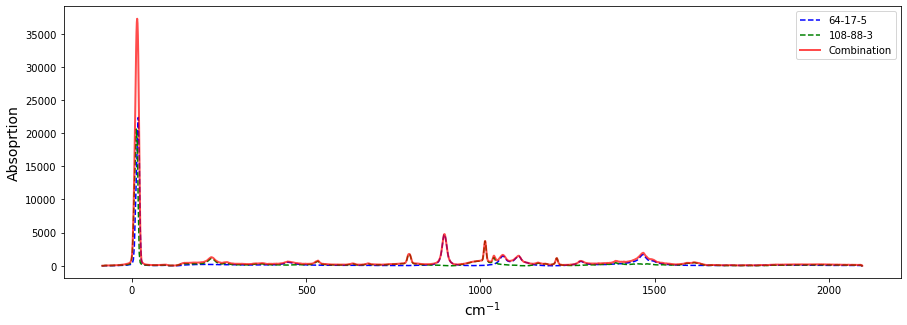

In [10]:
#unknown_x=np.array(list_spectrum_compound[0])
#unknown_y=np.array(list_spectrum_compound[1])
unknown_x, unknown_y = shoyu.combine_spectra(list_of_compounds[0], list_of_compounds[3], plot = True)#False or True
#peak_assignment(unknown_x, unknown_y, list_of_compounds,plot=False)

In [38]:
peak_assignment(unknown_x, unknown_y, list_of_compounds,plot=False)

False

In [ ]:
#unknown_peaks = data_report(unknown_x, unknown_y)[0]

In [11]:
y_data = subtract_baseline(unknown_y)
x_data = unknown_x
peaks = peak_detect(unknown_x, y_data,prominence=y_data.mean())[0]
mod, pars = set_params(peaks)

In [62]:
pars

name,value,initial value,min,max,vary,expression
p1_amplitude,1.00000000,None,0.00000000,inf,True,
p1_center,15.0000000,None,-inf,inf,False,
p1_sigma,50.0000000,None,0.00000000,500.000000,True,
p1_fraction,0.50000000,None,0.00000000,1.00000000,True,
p1_fwhm,100.000000,None,-inf,inf,False,2.0000000*p1_sigma
p1_height,37246.9904,None,-inf,inf,False,
p2_amplitude,1.00000000,None,0.00000000,inf,True,
p2_center,228.000000,None,-inf,inf,False,
p2_sigma,50.0000000,None,0.00000000,500.000000,True,
p2_fraction,0.50000000,None,0.00000000,1.00000000,True,


In [12]:
out = model_fit(x_data, y_data, mod, pars)#慢


In [64]:
out

In [13]:
fit_peak_data = export_fit_data(out)#快
peak_centers = []
peak_sigma = []
peak_ampl = []
# peak_height = []
print("开始循环")
for i, _ in enumerate(fit_peak_data):
    # peak_fractions.append(fit_peak_data[i][0])
    # if we ever need lorentzian fraction we can add it
    # right now it may break other functions 
    peak_sigma.append(fit_peak_data[i][1])
    peak_centers.append(fit_peak_data[i][2])
    peak_ampl.append(fit_peak_data[i][3])
    # peak_height.append(fit_peak_data[i][5])
xmin = min(x_data)
xmax = max(x_data)

开始循环


In [14]:
unknown_peaks=peak_centers

known_compound_list = list_of_compounds
known_compound_peaks = []
assignment_matrix = []
precision = 0.03
for i, _ in enumerate(known_compound_list):
    known_compound_peaks.append(compound_report(known_compound_list[i])[0])
    print("The peaks that we found for "
          + str(known_compound_list[i]['title']) + " are: ")
    print(known_compound_peaks[i])
    assignment_matrix.append(compare_unknown_to_known(unknown_peaks,
                                                      known_compound_peaks[i],
                                                      precision))



The peaks that we found for 64-17-5 are: 
[18.149, 447.26, 897.829, 1064.658, 1108.804, 1289.808, 1467.137]


KeyboardInterrupt: 

In [16]:
'auto'=="auto"

True

In [75]:
#Ok, so that generates a full association matrix that contains everything
#we need to assign peaks.
#Now, let's go through and actually assign text to peaks.
#print("spectrafit.data_report成功")
unknown_peak_assignments = peak_position_comparisons(unknown_peaks,
                                                     known_compound_peaks,
                                                     known_compound_list,
                                                     assignment_matrix)
print(unknown_peak_assignments)

percentages = percentage_of_peaks_found(known_compound_peaks,
                                        assignment_matrix,
                                        known_compound_list)



[['Unassigned'], ['108-88-3'], ['108-88-3'], ['64-17-5'], ['108-90-7', '108-88-3', '108-95-2'], ['64-17-5', '108-90-7', '108-88-3', '108-95-2'], ['64-17-5', '108-90-7', '108-88-3', '108-95-2'], ['64-17-5', '108-90-7'], ['67-66-3', '108-88-3'], ['64-17-5']]


unknown_peak_assignments is [['Unassigned'], ['108-88-3'], ['108-88-3'], ['64-17-5'], ['108-90-7', '108-88-3', '108-95-2'], ['64-17-5', '108-90-7', '108-88-3', '108-95-2'], ['64-17-5', '108-90-7', '108-88-3', '108-95-2'], ['64-17-5', '108-90-7'], ['67-66-3', '108-88-3'], ['64-17-5']]


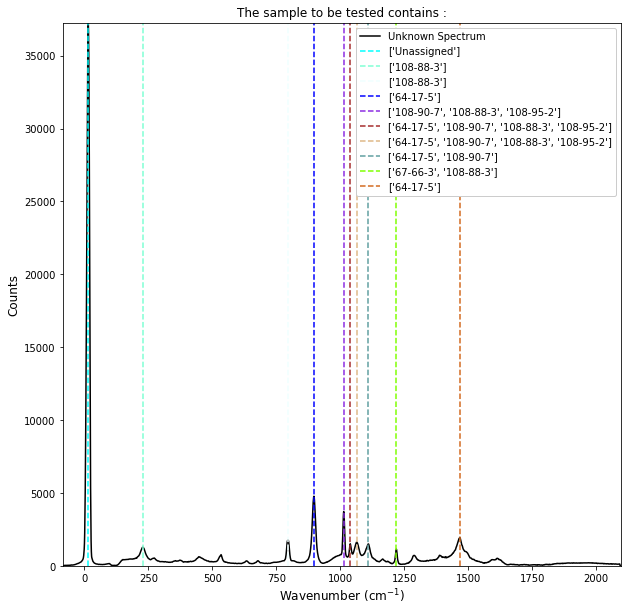

{'64-17-5': 71.42857142857143, '67-66-3': 16.666666666666664, '108-90-7': 57.14285714285714, '108-88-3': 66.66666666666666, '108-95-2': 33.33333333333333}


In [90]:
plot=True
if plot:
    plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks,
                              unknown_peak_assignments,percentages)

#percentages = percentage_of_peaks_found(known_compound_peaks,
#                                        assignment_matrix,
#                                        known_compound_list)
print(percentages)

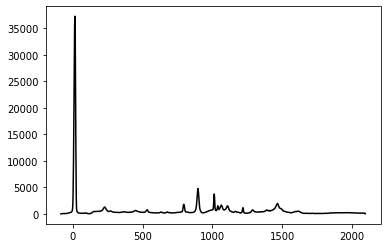

In [84]:
plt.plot(unknown_x, unknown_y, color='black', label='Unknown Spectrum')

In [91]:
list_of_compounds

[{'title': '64-17-5',
  'x': array([ -89.568,  -86.697,  -83.828, ..., 2095.591, 2097.12 , 2098.648]),
  'y': array([-1.51,  2.52,  1.51, ..., -0.5 , -0.5 , -5.54])},
 {'title': '67-66-3',
  'x': array([ -89.568,  -86.697,  -83.828, ..., 2095.591, 2097.12 , 2098.648]),
  'y': array([-0.25, -1.25, -1.25, ...,  1.75,  0.75, -1.25])},
 {'title': '108-90-7',
  'x': array([ -89.568,  -86.697,  -83.828, ..., 2095.591, 2097.12 , 2098.648]),
  'y': array([ 1.75,  0.75, -2.25, ...,  5.75, -2.25,  2.75])},
 {'title': '108-88-3',
  'x': array([ -89.568,  -86.697,  -83.828, ..., 2095.591, 2097.12 , 2098.648]),
  'y': array([-3.38, -1.38, -0.38, ..., -3.38,  3.62,  1.62])},
 {'title': '108-95-2',
  'x': array([ -89.568,  -86.697,  -83.828, ..., 2095.591, 2097.12 , 2098.648]),
  'y': array([-3.,  0., -4., ...,  0.,  3.,  0.])}]

In [17]:
aaa=(1,2)

In [18]:
aaa[0]

1